In this recipe, we'll work with a myoglobin/hemoglobin mulitple sequence alignment to create and view a visual summary of the alignment, and then to apply some filtering of sequences and positions in the alignment. Because by definition a mutliple sequence alignment contains sequences all of the same length, an alignment can be thought of as a matrix or table. A convenient way to get a visual summary of an alignment is with a heatmap. We're going to use the scikit-bio [``TabularMSA``](http://scikit-bio.org/docs/0.5.0/generated/skbio.alignment.TabularMSA.html) object for this, along with some information from the [AAIndex database](http://www.genome.jp/aaindex/), and [matplotlib](http://matplotlib.org/).

First we'll load a pre-existing multiple sequence alignment into a ``TabularMSA`` and set the MSA's index labels to the sequence identifiers read in from the FASTA file.

In [1]:
from skbio import TabularMSA, Protein

msa = TabularMSA.read('data/globin-aln.fasta', constructor=Protein)
msa.reassign_index(minter='id')

Next we're going to load the [AAIndex database](http://www.genome.jp/aaindex/) [hydrophobicity index values](http://www.genome.jp/dbget-bin/www_bget?aaindex:ARGP820101). This provides a measure of the hydrophobicity of all of the amino acids, where low values are associated with more hydrophilic amino acids, and high values are associated with more hydrophobic amino acids. We're going to use these in our visualization of the alignment.

In [2]:
# Data derived from AAIndex:
# http://www.genome.jp/dbget-bin/www_bget?aaindex:ARGP820101
import numpy as np
from collections import defaultdict
hydrophobicity_idx = defaultdict(lambda: np.nan)
hydrophobicity_idx.update({'A': 0.61, 'L': 1.53, 'R': 0.60, 'K': 1.15, 'N': 0.06, 'M': 1.18, 
                           'D': 0.46, 'F': 2.02, 'C': 1.07, 'P': 1.95, 'Q': 0., 'S': 0.05, 
                           'E': 0.47, 'T': 0.05, 'G': 0.07, 'W': 2.65, 'H': 0.61, 'Y': 1.88, 
                           'I': 2.22, 'V': 1.32})
hydrophobicity_labels=['Hydrophilic', 'Medium', 'Hydrophobic']

## Visualizing alignments

Next we'll define a function that makes use of matplotlib to generate a heatmap-style image of the alignment. In the future, this functionality will be a ``TabularMSA`` method ([#765](https://github.com/biocore/scikit-bio/issues/765)). The heatmap and legend code was adapted from the matplotlib gallery example [here](http://matplotlib.org/examples/pylab_examples/colorbar_tick_labelling_demo.html).

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def msa_to_heatmap(msa, value_map, legend_labels=('Low', 'Medium', 'High'), fig_size=(15,10), cmap='YlGn', sequence_order=None):
    """Plot a multiple sequence alignment as a heatmap.
    
    Parameters
    ----------
    msa : skbio.TabularMSA
        The multiple sequence alignment to be plotted
    value_map : dict, collections.defaultdict
        Dictionary mapping characters in the alignment to values. KeyErrors are not
        caught, so all possible values should be in this dict, or it should be a 
        collections.defaultdict which can, for example, default to ``nan``.
    legend_labels : iterable, optional
        Labels for the min, median, and max values in the legend.
    fig_size : tuple, optional
        Size of figure in inches.
    cmap : matplotlib colormap, optional
        See here for choices: http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
    sequence_order : iterable, optional
        The order, from top-to-bottom, that the sequences should be plotted in.
    
    Raises
    ------
    KeyError
        If a character in ``msa`` is not in ``value_map``, and ``value_map`` is not a 
        ``collections.defaultdict``.
        
    """
    if sequence_order is None:
        sequence_order = msa.index
            
    # fill a data matrix by iterating over the alignment and mapping
    # characters to values
    mtx = []
    for label in sequence_order:
        seq = str(msa.loc[label])
        mtx.append([value_map[aa] for aa in seq])
        
    # build the heatmap, this code derived from the Matplotlib Gallery
    # http://matplotlib.org/examples/pylab_examples/colorbar_tick_labelling_demo.html
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size)

    cax = ax.imshow(mtx, interpolation='nearest', cmap=cmap)

    # Add colorbar and define tick labels
    values = list(value_map.values())
    cbar = fig.colorbar(cax, 
                        ticks=[min(values), 
                               np.nanmedian(values),
                               max(values)],
                        orientation='horizontal')
    ax.set_yticks([0] + list(range(3, msa.shape.sequence - 3, 3)) + [msa.shape.sequence - 1])
    ax.set_yticklabels(sequence_order)
    ax.set_xticks(range(msa.shape.position))
    ax.set_xticklabels(msa.consensus(), size=7)
    cbar.ax.set_xticklabels(legend_labels) # horizontal colorbar

We can now use this function to visualize our alignment. Note that the human hemoglobin sequence, which is the top-most one, is clearly the most different. We can also clearly see that hydrophobicity is highly conserved, as is illustrated by vertical bands that are similar in color. Some select sequence identifiers are used on the y-axis as labels, and the x-axis is the majority consensus character (either an amino acid abbreviation or a gap character) at each position in the alignment.

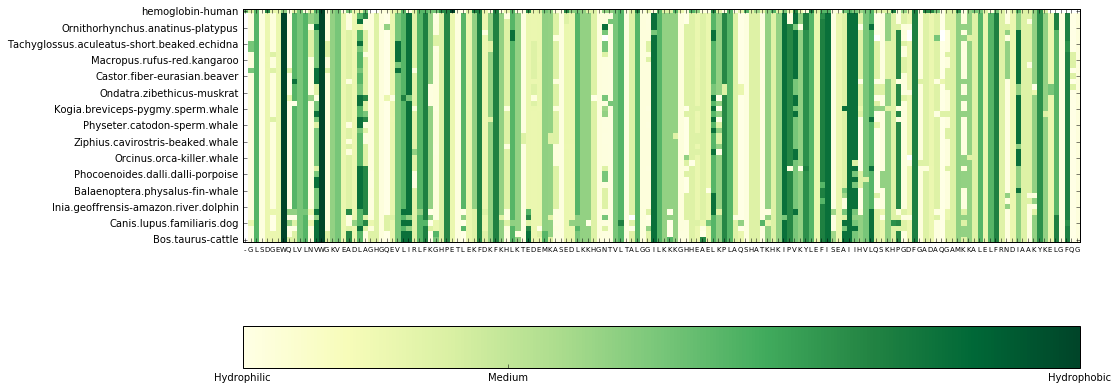

In [4]:
msa_to_heatmap(msa, hydrophobicity_idx, legend_labels=hydrophobicity_labels)

One limitation in the above plot is that there isn't any order to the sequences. If we want to vertically group sequences from more closely related organisms, we can build a neighbor joining tree from the alignment, perform outgroup rooting, and then traverse over the resulting tips to define the order.

In [5]:
from skbio import DistanceMatrix
from skbio.sequence.distance import hamming
from skbio.tree import nj

dm = DistanceMatrix.from_iterable(msa, metric=hamming, keys=msa.index)
tree = nj(dm)
new_root = tree.find('hemoglobin-human').ancestors()[0]
outgroup_rooted_tree = tree.root_at(new_root)
sequence_order = [t.name for t in outgroup_rooted_tree.tips()]

We can then pass that order in, and we'll see that more similar organisms are now better grouped then they were above. Similarly, the vertical bands are now more consistent in color, since each pair of adjacent rows in the matrix are now from organisms that diverged from one another more recently.

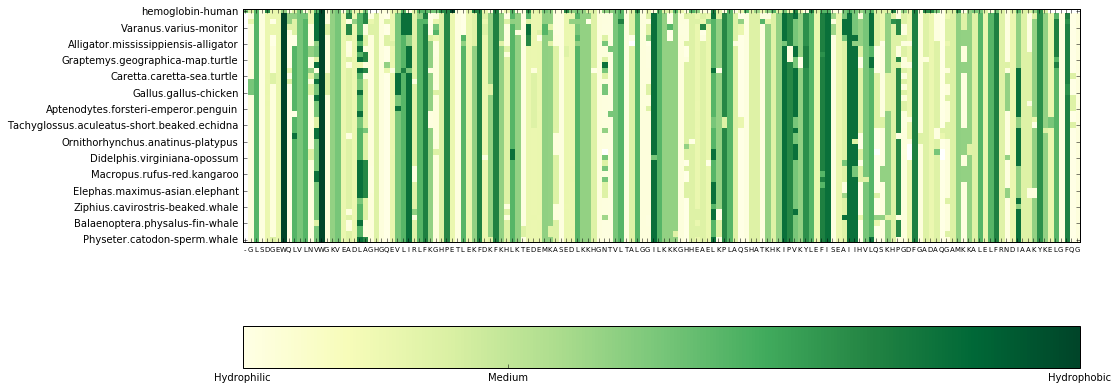

In [6]:
msa_to_heatmap(msa, hydrophobicity_idx, legend_labels=hydrophobicity_labels, sequence_order=sequence_order)

## Filtering alignments

The ``TabularMSA`` object supports a variety of slicing operations, allowing users to filter sequences and/or positions from the alignment. The examples in this notebook only illustrate a couple of ways to slice a ``TabularMSA``: using a boolean vector and labels. Briefly, a boolean vector is a 1-D ``array_like`` of boolean values identifying sequences or positions to retain or discard. For more examples of supported slicing operations, see [``TabularMSA.loc``](http://scikit-bio.org/docs/0.5.0/generated/skbio.alignment.TabularMSA.loc.html) for label-based slicing and [``TabularMSA.iloc``](http://scikit-bio.org/docs/0.5.0/generated/skbio.alignment.TabularMSA.iloc.html) for index position-based slicing. In the following examples, we use [``TabularMSA.__getitem__``](http://scikit-bio.org/docs/0.5.0/generated/skbio.alignment.TabularMSA.__getitem__.html) (i.e. the ``[]`` syntax) to slice with boolean vectors. This is simply an alias for ``TabularMSA.iloc``. Slicing by a boolean vector can be performed equivalently using ``[]`` syntax (as illustrated below), ``TabularMSA.loc``, or ``TabularMSA.iloc``.

Imagine you wanted to exclude the perfectly conserved and most variable positions in the alignment for a phylogenetic reconstruction process. You might want to do this because the most variable positions may be ones that are essentially unconserved, and therefore are only noise for the tree building process. The most perfectly conserved positions, on the other hand, don't contain any useful information about the relationships between the organisms, so can only increase the runtime of phylogenetic reconstruction without improving the quality of the tree.

We can perform conservation-based positional filtering by making use of [``TabularMSA.conservation``](http://scikit-bio.org/docs/0.5.0/generated/skbio.alignment.TabularMSA.conservation.html), which will provide a measure of conservation for each position in the alignment. Positional conservation is discussed in more detail in [the neighbor joining recipe](./Alignments%20and%20phylogenetic%20reconstruction.ipynb).

First, compute conservation for each position in the alignment:

In [7]:
positional_conservation = msa.conservation(metric='inverse_shannon_uncertainty', degenerate_mode='nan', gap_mode='nan')

Next, use the positional conservation array to create a boolean vector indicating positions to retain or discard, and slice the second axis (positions) with the boolean vector:

In [8]:
filtered_msa = msa[:, (positional_conservation >= 0.15) & (positional_conservation < 1.0)]

After this process we have only 119 positions of our original 154 positions. We can visualize this to see that we no longer have any perfectly conserved positions, and the least conserved positions have also been filtered out.

In [9]:
filtered_msa

TabularMSA[Protein]
-----------------------------------------------------------------------
Stats:
    sequence count: 43
    position count: 119
-----------------------------------------------------------------------
HTPEKSATALGNVDEVGEALGRLLVVYWQRFES ... GNVLVCVLHHFGKTPPVAYQKVVAGVANALHKH
GSDGWQLLKVGEGDLPQEVLIRLFKTHELEKDK ... SEAIIHVLSKHSAGADAAMGKALELFRNDMAKK
...
GSDDWNHLGIAEPDLSQEVIIRLFQLHEQERAK ... CEIIVKVIEKHPSGADSAMKKALELFRNDMSKK
GSDDWHHLGIAEPDLSQEVIIRLFQVHEQERAK ... CEIIVKVIEKHPSGADSAMRKALELFRNDMSKK

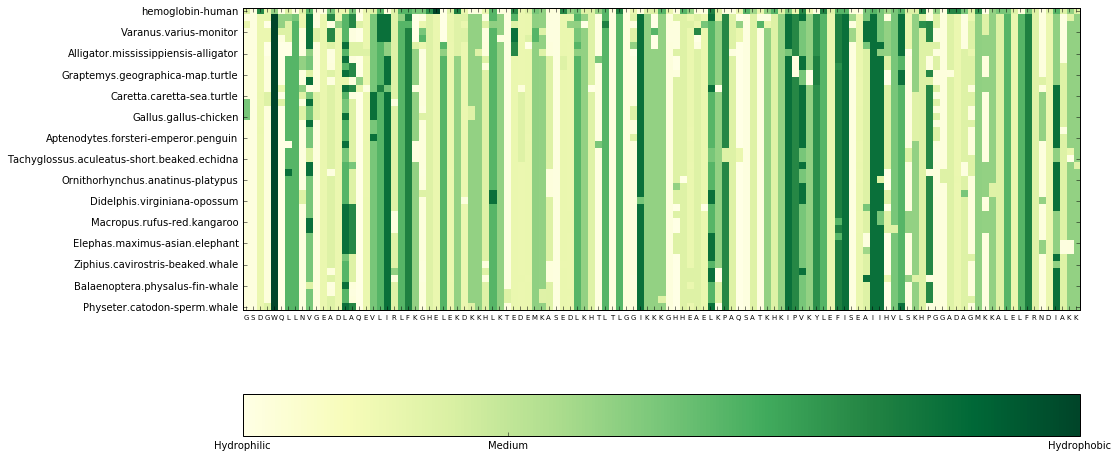

In [10]:
msa_to_heatmap(filtered_msa, hydrophobicity_idx, legend_labels=hydrophobicity_labels, sequence_order=sequence_order)

We can also filter sequences from the alignment. For example, maybe we want to exclude our hemoglobin sequence, since it's a paralog of all of the other sequences in the alignment. We can do that by finding the name of the sequence (it's in our ``sequence_order`` list and in ``msa.index``). Rather than having to pass the names of the sequences we want to keep, we can create a boolean vector excluding the single hemoglobin sequence and slice the alignment with it:

In [11]:
myoglobin_msa = msa[msa.index != 'hemoglobin-human']

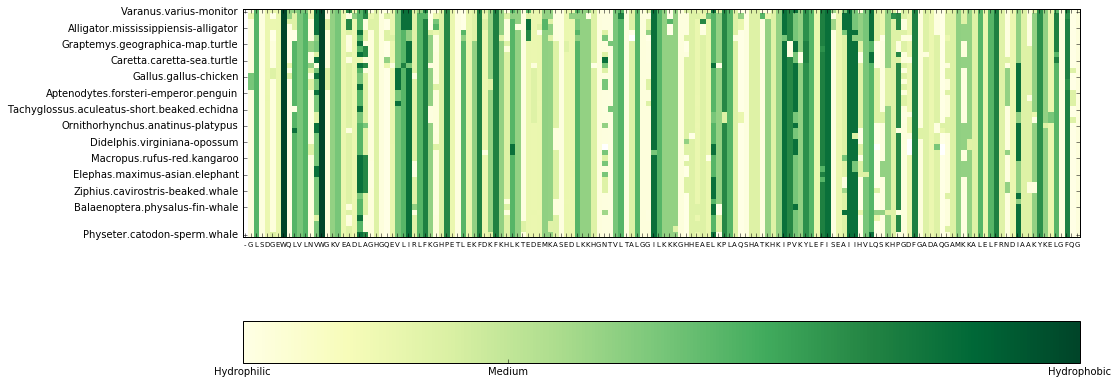

In [12]:
msa_to_heatmap(myoglobin_msa, hydrophobicity_idx, legend_labels=hydrophobicity_labels, sequence_order=sequence_order[1:])

Similarly, if we want to keep only the sequences in some specific taxonomic group, we could identify those names and slice using ``TabularMSA.loc``, which performs label-based slicing. Here we'll get the alignment of only the whale sequences.

In [13]:
whale_sequence_ids = [e for e in sequence_order if e.endswith('whale')]
whale_msa = msa.loc[whale_sequence_ids]

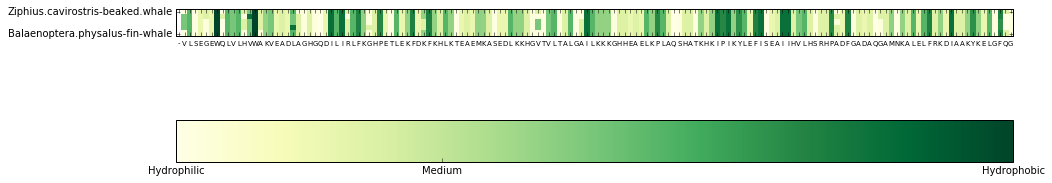

In [14]:
msa_to_heatmap(whale_msa, hydrophobicity_idx, legend_labels=hydrophobicity_labels, sequence_order=whale_sequence_ids)